In [387]:
# 초기 밑작업은 동일하게 수행 
import pandas as pd
import numpy as np

df = pd.read_csv('./auto-mpg.data', sep='\s+',names=["displacement","mpg","cylinders",
                                               "horsepower","weight","acceleration", "model_year", "origin", "car_name"])
for i in df.columns :
    df[i]=df[i].replace("?",np.nan)
df["horsepower"]=df["horsepower"].astype("float64")
df.drop(df[df["horsepower"].isnull()].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [388]:
# 추가로, Z-score로 자르기
import scipy.stats as stats

z = np.abs(stats.zscore(df[df.columns[:-1]])) 
index,_=np.where(z>3) # 16개의 데이터 제거
df[(z<=3).all(axis=1)].reset_index(drop=True, inplace=True)

In [389]:
# # PolynomialFeatures 말고도 여러 Features를 만들어주는 다른 sklearn 을 갖고옴
# # cylinders, horsepower 관련 열 추가
# from sklearn.preprocessing import SplineTransformer

# target=df["mpg"]
# feature=df[["cylinders", "horsepower"]]
# spline = SplineTransformer(degree=2, n_knots=3)
# df2=pd.DataFrame(spline.fit_transform(feature), columns=spline.get_feature_names_out()) # DataFrame으로 변환
# df = pd.concat([target,df2],axis=1) # DataFrame 병합 




# -> SplineTransformer : 별 효과 없다 

In [390]:
import numpy as np
from sklearn.preprocessing import QuantileTransformer



target=df["mpg"]
feature=df[["cylinders", "horsepower"]]
qt = QuantileTransformer(n_quantiles=10, random_state=0)
df2=pd.DataFrame(qt.fit_transform(feature), columns=qt.get_feature_names_out()) # DataFrame으로 변환
df = pd.concat([target,df2],axis=1) # DataFrame 병합 

In [391]:
df

,mpg,cylinders,horsepower
0,8,0.788889,0.748634
1,8,0.888889,0.906743
2,8,0.814470,0.870504
3,8,0.781912,0.870504
4,8,0.777426,0.798561
...,...,...,...
387,4,0.444444,0.370370
388,4,0.206349,0.031746
389,4,0.417989,0.333333
390,4,0.338624,0.271605


In [392]:
df.corr()["mpg"]  # cylinders_sp_2와 horsepower_sp_2를 사용해보자 

mpg           1.000000
cylinders     0.918897
horsepower    0.836235
Name: mpg, dtype: float64

In [393]:
from sklearn.model_selection import train_test_split 
# 데이터 셋 생성 
target = df["mpg"]
feaature = df[["cylinders","horsepower"]]
x_train, x_test, y_train, y_test = train_test_split(feature, 
                                                    target, 
                                                    test_size=0.5)

In [394]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # 정규화 
std_scaler=StandardScaler()
mm_scaler=MinMaxScaler()
rb_scaler=RobustScaler()
sl=[std_scaler, mm_scaler, rb_scaler]

sv= [[],[],[]]
sv2=[[],[],[]]

for i,v in enumerate(sl) :
    v.fit(x_train)
    sv[i]=v.transform(x_train).copy()
    v.fit(x_test)
    sv2[i]=v.transform(x_test).copy()
    
    
x_train_std=sv[0]
x_train_mm=sv[1]
x_train_rb=sv[2]
x_test_std=sv2[0]
x_test_mm=sv2[1]
x_test_rb=sv2[2]

In [395]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

model_list=[LinearRegression(), KNeighborsRegressor(), RandomForestRegressor(), SVR()] # LinearRegression을 포함한 여러 분석 모델 제시 

dataset=[x_train_std, x_train_mm, x_train_rb, x_test_std, x_test_mm, x_test_rb]
score_list=[]
for j in model_list:
    for i in range(int(len(dataset)/2)) :
        model=j
        model.fit(dataset[i], y_train)
        train_score=model.score(dataset[i], y_train)
        model.fit(dataset[i+3], y_test)
        test_score=model.score(dataset[i+3], y_test)
        y_pre=model.predict(dataset[i+3])
        mse=mean_squared_error(y_test, y_pre, squared=False)
        mae=mean_absolute_error(y_test, y_pre)
        score_list.append([train_score, test_score, mse, mae])


In [396]:
len(score_list)

12

In [397]:
model_list=["LinearRegression", "KNeighborsRegressor", "RandomForestRegressor", "SVR"]
for i in range(4):
    print(f'{model_list[i]}으로 분석 : ')
    print(f'\ttrain_score : {round(score_list[i*3][0]*100,1)}%')
    print(f'\ttest_score : {round(score_list[i*3][1]*100,1)}%')
    print(f'\tmse_score : {score_list[i*3][2]:.2}')
    print(f'\tmae_score : {score_list[i*3][3]:.2}')

LinearRegression으로 분석 : 
	train_score : 90.3%
	test_score : 90.8%
	mse_score : 0.52
	mae_score : 0.39
KNeighborsRegressor으로 분석 : 
	train_score : 96.6%
	test_score : 98.0%
	mse_score : 0.24
	mae_score : 0.062
RandomForestRegressor으로 분석 : 
	train_score : 99.6%
	test_score : 99.6%
	mse_score : 0.11
	mae_score : 0.028
SVR으로 분석 : 
	train_score : 94.9%
	test_score : 96.0%
	mse_score : 0.34
	mae_score : 0.18


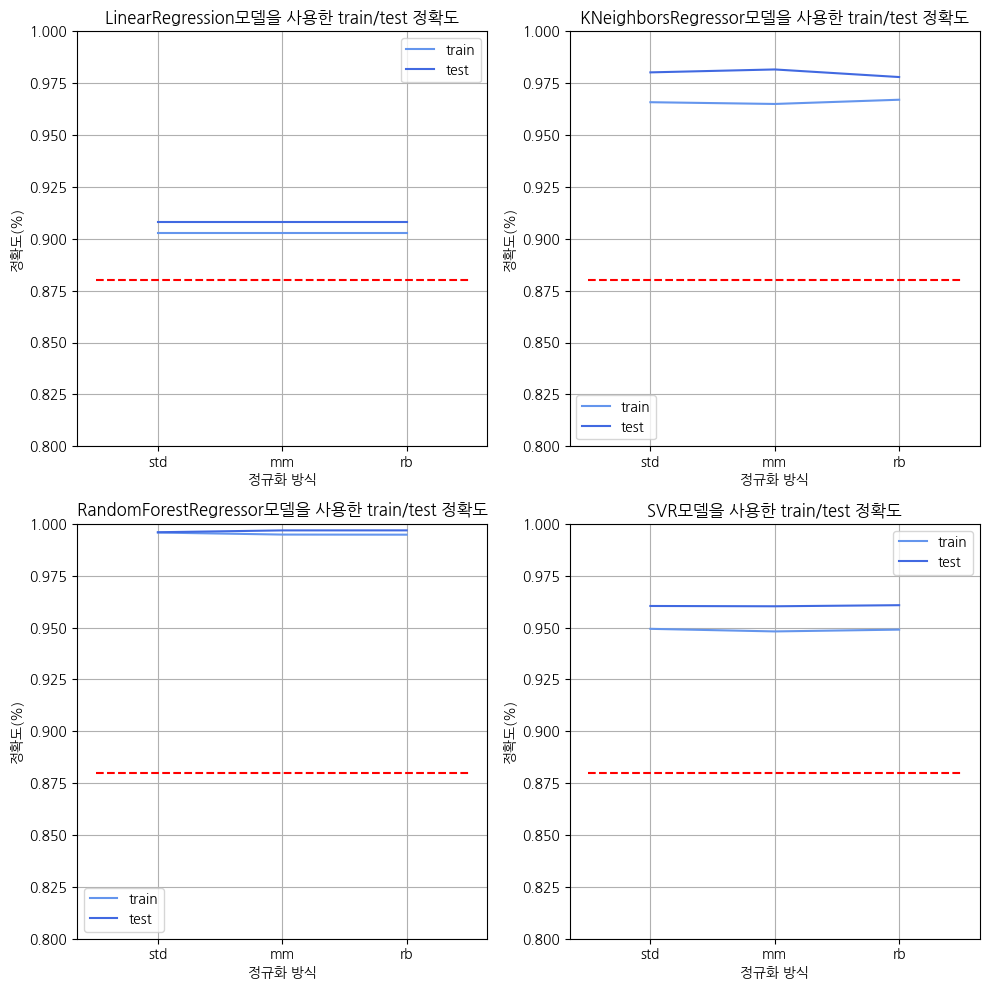

In [398]:
import koreanize_matplotlib
import matplotlib.pyplot as plt


plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    data=np.array(score_list[i*3:i*3+3]).T
    plt.plot(range(3), data[0], color='cornflowerblue', label='train')
    plt.plot(range(3), data[1], color='royalblue', label='test')
    plt.legend()
    plt.hlines(y=0.88, xmin=-0.5, xmax=2.5, colors='r', linestyles='dashed', label='Horizontal Line')
    plt.xticks(range(3), ['std', 'mm', 'rb'])
    plt.xlabel("정규화 방식")
    plt.ylabel("정확도(%)")
    plt.title(f"{model_list[i]}모델을 사용한 train/test 정확도")
    plt.ylim(0.8, 1)
    plt.grid(True)
    plt.savefig("PolyFeature True.png")
plt.tight_layout()
plt.show()

In [399]:
# # z-score로 변화를 주었고, 다양한 모델을 사용하였다

# LinearRegression으로 분석 : 
# 	train_score : 90.3%
# 	test_score : 90.8%
# 	mse_score : 0.52
# 	mae_score : 0.39
# KNeighborsRegressor으로 분석 : 
# 	train_score : 96.6%
# 	test_score : 98.0%
# 	mse_score : 0.24
# 	mae_score : 0.062
# RandomForestRegressor으로 분석 : 
# 	train_score : 99.6%
# 	test_score : 99.6%
# 	mse_score : 0.11
# 	mae_score : 0.028
# SVR으로 분석 : 
# 	train_score : 94.9%
# 	test_score : 96.0%
# 	mse_score : 0.34
# 	mae_score : 0.18

# => 랜덤포레스트 >>>>(벽)>>>> KNeighbor 늑 SVR > Linear 순으로 정확도가 판가름 남
# 앙상블 기법이 제일 좋으며, KNeighbor도 좋다 